# Combine preprocessed surveys

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import glob
import re
import os
from collections import Counter
import numpy as np

In [2]:
basedir = '../../data/eurobarometer/'
step1_dir = basedir + "step1/"
step2_dir = basedir + "step2/"
os.makedirs(step2_dir, exist_ok=True)

## Combine dfs

Load the individual dfs and drop columns for languages not mentioned by any of the respondents.

In [3]:
dfs = []
for filepath in glob.glob(step1_dir + "*"):
    dfs.append(pd.read_csv(filepath))
    
eval_df = pd.concat(dfs, ignore_index=True)
eval_df = eval_df.loc[:, eval_df.sum() != 0]
eval_df = eval_df.rename({'isocntry': 'Country'}, axis=1)

eval_df.head()

,Country,L1_Danish,L1_German,L1_French,L1_Italian,L1_Dutch,L1_English,L1_Spanish,L1_Portuguese,L1_Greek,...,L2_Gujarati,L2_Hindi,L2_Other Regional,L2_Punjabi,L2_Urdu,L1_Korean,L1_Scottish Gaelic,L1_Welsh,L2_Scottish Gaelic,L2_Welsh
0,DE,0,1,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DE,0,1,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DE,0,1,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DE,0,1,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DE,0,1,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def fillna(eval_df, lang1, lang2):
    """
    Fill NaNs in L1 and L2 columns for lang1 with values from column for lang2.
    Reasoning: Languages might not occur under the name name in every survey, but results should be unified under one name.
    """
    _combine_inplace(eval_df, f'L1_{lang1}', f'L1_{lang2}')
    _combine_inplace(eval_df, f'L2_{lang1}', f'L2_{lang2}')

def _combine_inplace(eval_df, key1, key2):
    eval_df[key1].fillna(eval_df[key2], inplace=True)
    eval_df.drop(key2, inplace=True, axis=1)

Combine survey results for Irish/Gaelic, Irish, and Scottish Gaelic and treat them as one language.

In [5]:
fillna(eval_df, 'Irish / Gaelic', 'Irish')
fillna(eval_df, 'Irish / Gaelic', 'Scottish Gaelic')

Some surveys go into more detail language-wise and ask about particular dialects, regional or foreign languages which are not polled in the majority of the available surveys. Just treat them as "other" language in the future, as time series analysis does not make sense in those cases.

## Drop the least queried languages

In [6]:
# Find the 12 L1/L2s which appear in the fewest surveys.
# Display the percentage of surveys where they do NOT occur.
least_commonly_asked = eval_df.isna().sum().nlargest(12) / len(eval_df)
display(least_commonly_asked)

ls = least_commonly_asked.index
l1s = [l for l in ls if l.startswith('L1')]
l2s = [l for l in ls if l.startswith('L2')]

L1_Korean            0.868370
L1_Welsh             0.868370
L2_Welsh             0.868370
L1_Other Regional    0.858991
L1_Punjabi           0.858991
L1_Gujarati          0.858991
L1_Bengali           0.858991
L2_Gujarati          0.858991
L2_Other Regional    0.858991
L2_Punjabi           0.858991
L1_Norwegian         0.855911
L2_Norwegian         0.855911
dtype: float64

In [7]:
def sum_columns(eval_df, key, cols):
    """
    For any respondent who mentioned one of the languages in cols, set 'other' language mentioned to 1. 
    Drop cols from data.
    
    key - Column which should take on OR(cols)
    cols - Columns to combine and drop
    """
    
    cols = eval_df.columns.intersection(cols)
    n_other = eval_df[key].sum()
    eval_df[[key, *cols]].fillna(0).drop_duplicates()
    eval_df[key] = eval_df[key] + eval_df[cols].fillna(0).sum(axis=1)
    eval_df[key] = eval_df[key].clip(0,1)
    eval_df = eval_df.drop(cols, axis=1, errors='ignore')
    print(f"Number of respondents who mentioned one of the given languages: {eval_df[key].sum() - n_other}/{len(eval_df)}")
    
    return eval_df

In [8]:
eval_df = sum_columns(eval_df, 'L1_Other', l1s)
eval_df = sum_columns(eval_df, 'L2_Other', l2s)
eval_df.columns.sort_values()

Number of respondents who mentioned one of the given languages: 176.0/203228
Number of respondents who mentioned one of the given languages: 971.0/203228


Index(['Country', 'L1_Arabic', 'L1_Basque', 'L1_Bulgarian', 'L1_Catalan',
       'L1_Chinese', 'L1_Croatian', 'L1_Czech', 'L1_Danish', 'L1_Dutch',
       'L1_English', 'L1_Estonian', 'L1_Finnish', 'L1_French', 'L1_Galician',
       'L1_German', 'L1_Greek', 'L1_Hindi', 'L1_Hungarian',
       'L1_Irish / Gaelic', 'L1_Italian', 'L1_Japanese', 'L1_Latvian',
       'L1_Lithuanian', 'L1_Luxembourgish', 'L1_Maltese', 'L1_Other',
       'L1_Polish', 'L1_Portuguese', 'L1_Romanian', 'L1_Russian',
       'L1_Sign Language', 'L1_Slovak', 'L1_Slovenian', 'L1_Spanish',
       'L1_Swedish', 'L1_Turkish', 'L1_Urdu', 'L2_Arabic', 'L2_Basque',
       'L2_Bulgarian', 'L2_Catalan', 'L2_Chinese', 'L2_Croatian', 'L2_Czech',
       'L2_Danish', 'L2_Dutch', 'L2_English', 'L2_Estonian', 'L2_Finnish',
       'L2_French', 'L2_Galician', 'L2_German', 'L2_Greek', 'L2_Hindi',
       'L2_Hungarian', 'L2_Irish / Gaelic', 'L2_Italian', 'L2_Japanese',
       'L2_Latvian', 'L2_Lithuanian', 'L2_Luxembourgish', 'L2_Maltes

## Aggregate microdata

Aggregate microdata and normalize, since the number of respondents is wildly different for each year and country.

In [9]:
n = eval_df.groupby(['Country', 'Year']).size()
agg = eval_df.groupby(['Country', 'Year']).sum()
display(agg.head())
agg = agg.div(n, axis=0)
agg.to_csv(step2_dir + 'eval_df_wide.csv')
agg.head()

L1_Danish  L1_German  L1_French  L1_Italian  L1_Dutch  \
Country Year                                                          
AT      1995          5        980          3           1         0   
        1998          1        989          2           3         0   
        1999          5        985          0           0         2   
        2000          6        933          7           2         0   
        2001          2        998          3           0         1   

              L1_English  L1_Spanish  L1_Portuguese  L1_Greek  L1_Other  ...  \
Country Year                                                             ...   
AT      1995           1           0              0         1      11.0  ...   
        1998           8           2              0         2      34.0  ...   
        1999           5           1              0         1      17.0  ...   
        2000          13           0              0         5      28.0  ...   
        2001           3           1              0         1      25.0  ...   

              L2_Polish  L2_Romanian  L2_Slovak  L2_Slovenian  L1_Galician  \
Country Year                                                                 
AT      1995        0.0          0.0        0.0           0.0          0.0   
        1998        0.0          0.0        0.0           0.0          0.0   
        1999        0.0          0.0        0.0           0.0          0.0   
        2000        0.0          0.0        0.0           0.0          0.0   
        2001        0.0          0.0        0.0           0.0          0.0   

              L1_Hindi  L1_Urdu  L2_Galician  L2_Hindi  L2_Urdu  
Country Year                                                     
AT      1995       0.0      0.0          0.0       0.0      0.0  
        1998       0.0      0.0          0.0       0.0      0.0  
        1999       0.0      0.0          0.0       0.0      0.0  
        2000       0.0      0.0          0.0       0.0      0.0  
        2001       0.0      0.0          0.0       0.0      0.0  

[5 rows x 74 columns]

L1_Danish  L1_German  L1_French  L1_Italian  L1_Dutch  \
Country Year                                                          
AT      1995   0.004985   0.977069   0.002991    0.000997  0.000000   
        1998   0.000959   0.948226   0.001918    0.002876  0.000000   
        1999   0.004912   0.967583   0.000000    0.000000  0.001965   
        2000   0.006122   0.952041   0.007143    0.002041  0.000000   
        2001   0.001932   0.964251   0.002899    0.000000  0.000966   

              L1_English  L1_Spanish  L1_Portuguese  L1_Greek  L1_Other  ...  \
Country Year                                                             ...   
AT      1995    0.000997    0.000000            0.0  0.000997  0.010967  ...   
        1998    0.007670    0.001918            0.0  0.001918  0.032598  ...   
        1999    0.004912    0.000982            0.0  0.000982  0.016699  ...   
        2000    0.013265    0.000000            0.0  0.005102  0.028571  ...   
        2001    0.002899    0.000966            0.0  0.000966  0.024155  ...   

              L2_Polish  L2_Romanian  L2_Slovak  L2_Slovenian  L1_Galician  \
Country Year                                                                 
AT      1995        0.0          0.0        0.0           0.0          0.0   
        1998        0.0          0.0        0.0           0.0          0.0   
        1999        0.0          0.0        0.0           0.0          0.0   
        2000        0.0          0.0        0.0           0.0          0.0   
        2001        0.0          0.0        0.0           0.0          0.0   

              L1_Hindi  L1_Urdu  L2_Galician  L2_Hindi  L2_Urdu  
Country Year                                                     
AT      1995       0.0      0.0          0.0       0.0      0.0  
        1998       0.0      0.0          0.0       0.0      0.0  
        1999       0.0      0.0          0.0       0.0      0.0  
        2000       0.0      0.0          0.0       0.0      0.0  
        2001       0.0      0.0          0.0       0.0      0.0  

[5 rows x 74 columns]

Bring aggregate data into long form for more efficient handling and easy plotting. 

In [10]:
x = agg.reset_index().reset_index().rename({'index': 'id'}, axis=1)
x = pd.wide_to_long(x, stubnames=['L1','L2'], i='id',j='Language', sep='_', suffix='.*')
x = x.reset_index().set_index(['Country', 'Language'])
x = x.loc[x.groupby(['Country', 'Language']).size() > 2]
x = x.reset_index()

agg_long = x
agg_long.head()

,Country,Language,id,Year,L1,L2
0,AT,Arabic,0,1995,0.0,0.002991
1,AT,Basque,0,1995,0.0,0.000000
2,AT,Bulgarian,0,1995,0.0,0.000000
3,AT,Catalan,0,1995,0.0,0.000000
4,AT,Chinese,0,1995,0.0,0.000000


Fill in missing values for smoother data without adding too much information which could lead to misinterpretation. If a language was queried in 1990 and 1995, but not in 1992, it will be mostly safe to assume that the 1992 value will be in the same ball park. If data is missing for many consecutive surveys, this prediction might be misleading and should not be made.

In [11]:
a = agg_long.replace(0, np.NaN).groupby(['Language', 'Country']).ffill(limit=2)[['L1', 'L2']]
agg_long = agg_long.replace(0, np.NaN).fillna(a).fillna(0)
agg_long.to_csv(step2_dir + 'eval_df_long.csv')

## Plot data

In [12]:
sns.set_style('darkgrid')
pal = sns.color_palette() + sns.color_palette('pastel') + sns.color_palette('dark') + sns.color_palette("Set2")

### L1 data

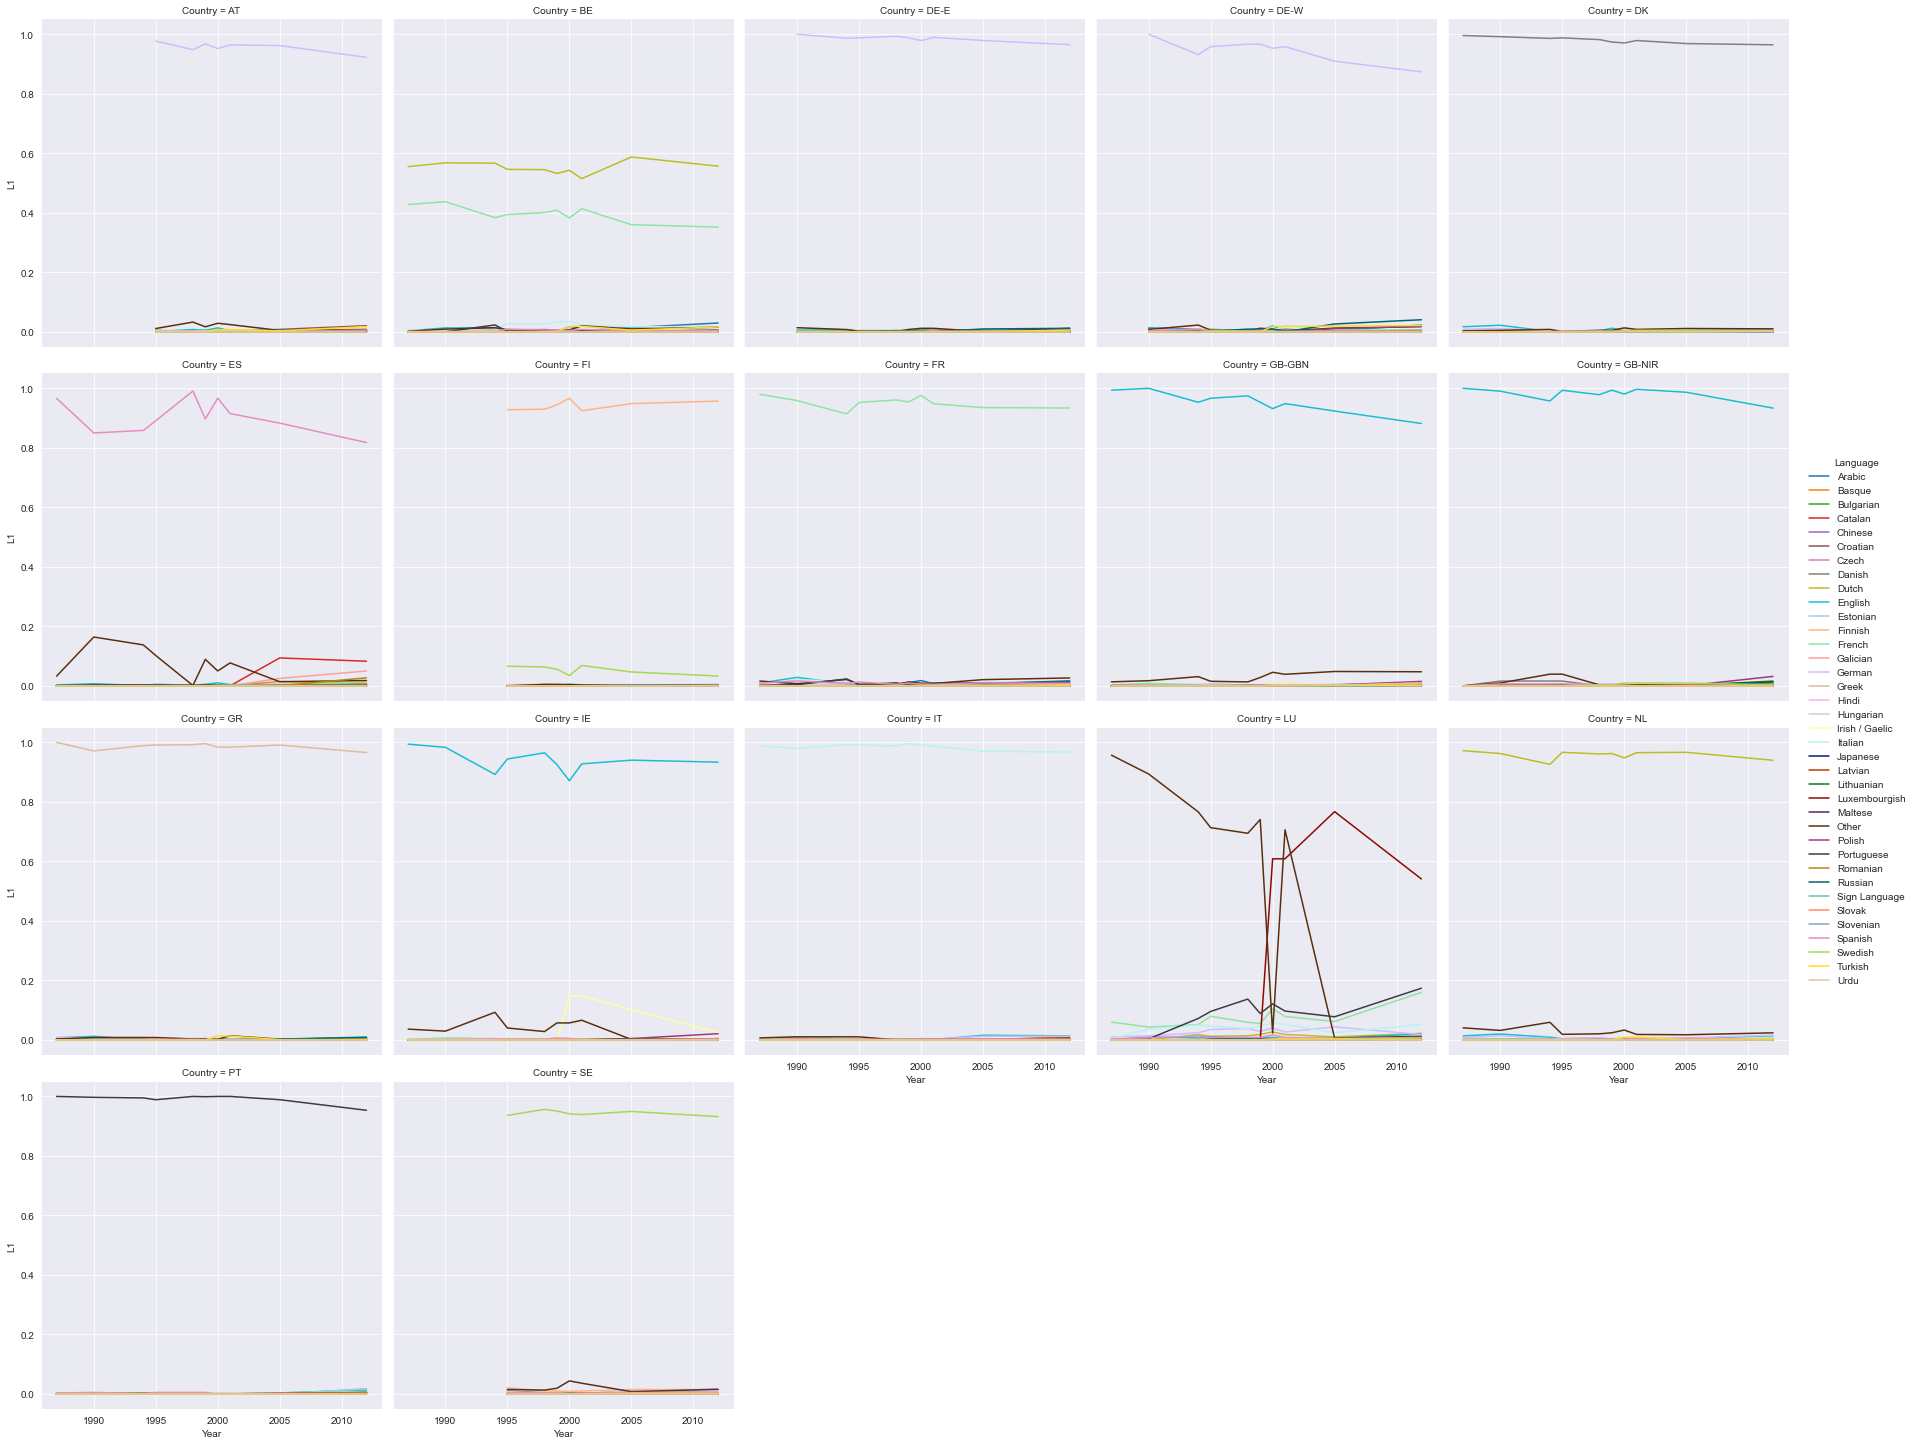

In [13]:
sns.relplot(
    data=agg_long,
    x="Year", y="L1",
    hue="Language", col='Country', col_wrap=5,
    kind="line", palette=pal[:len(agg_long.Language.unique())]
)

### L2 data

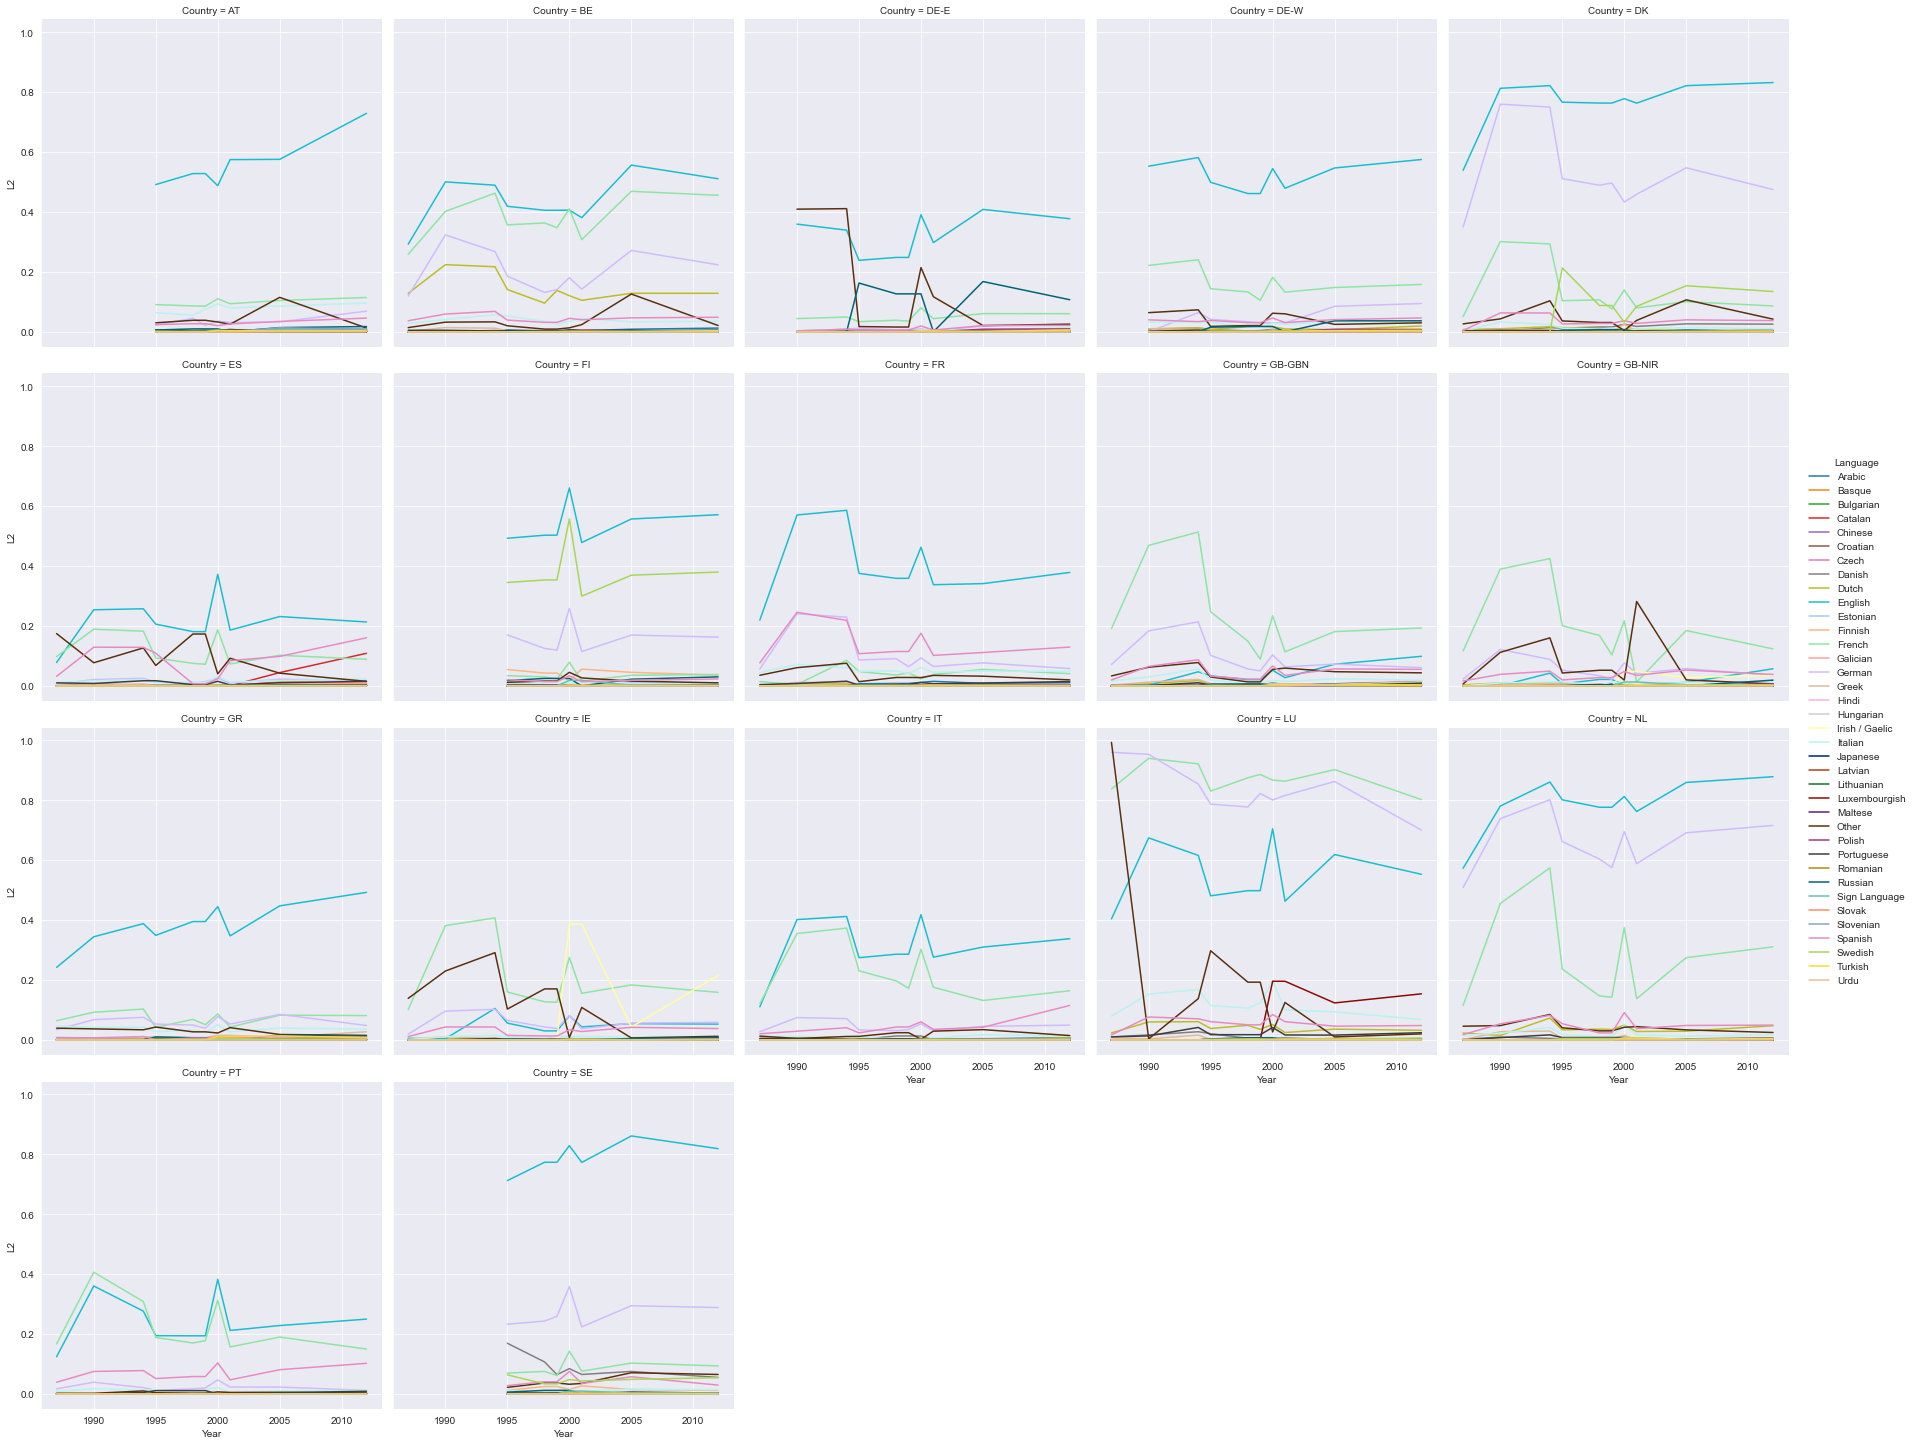

In [14]:
sns.relplot(
    data=agg_long,
    x="Year", y="L2",
    hue="Language", col='Country', col_wrap=5,
    kind="line", palette=pal[:len(agg_long.Language.unique())]
)

### L1 data without majority language(s)

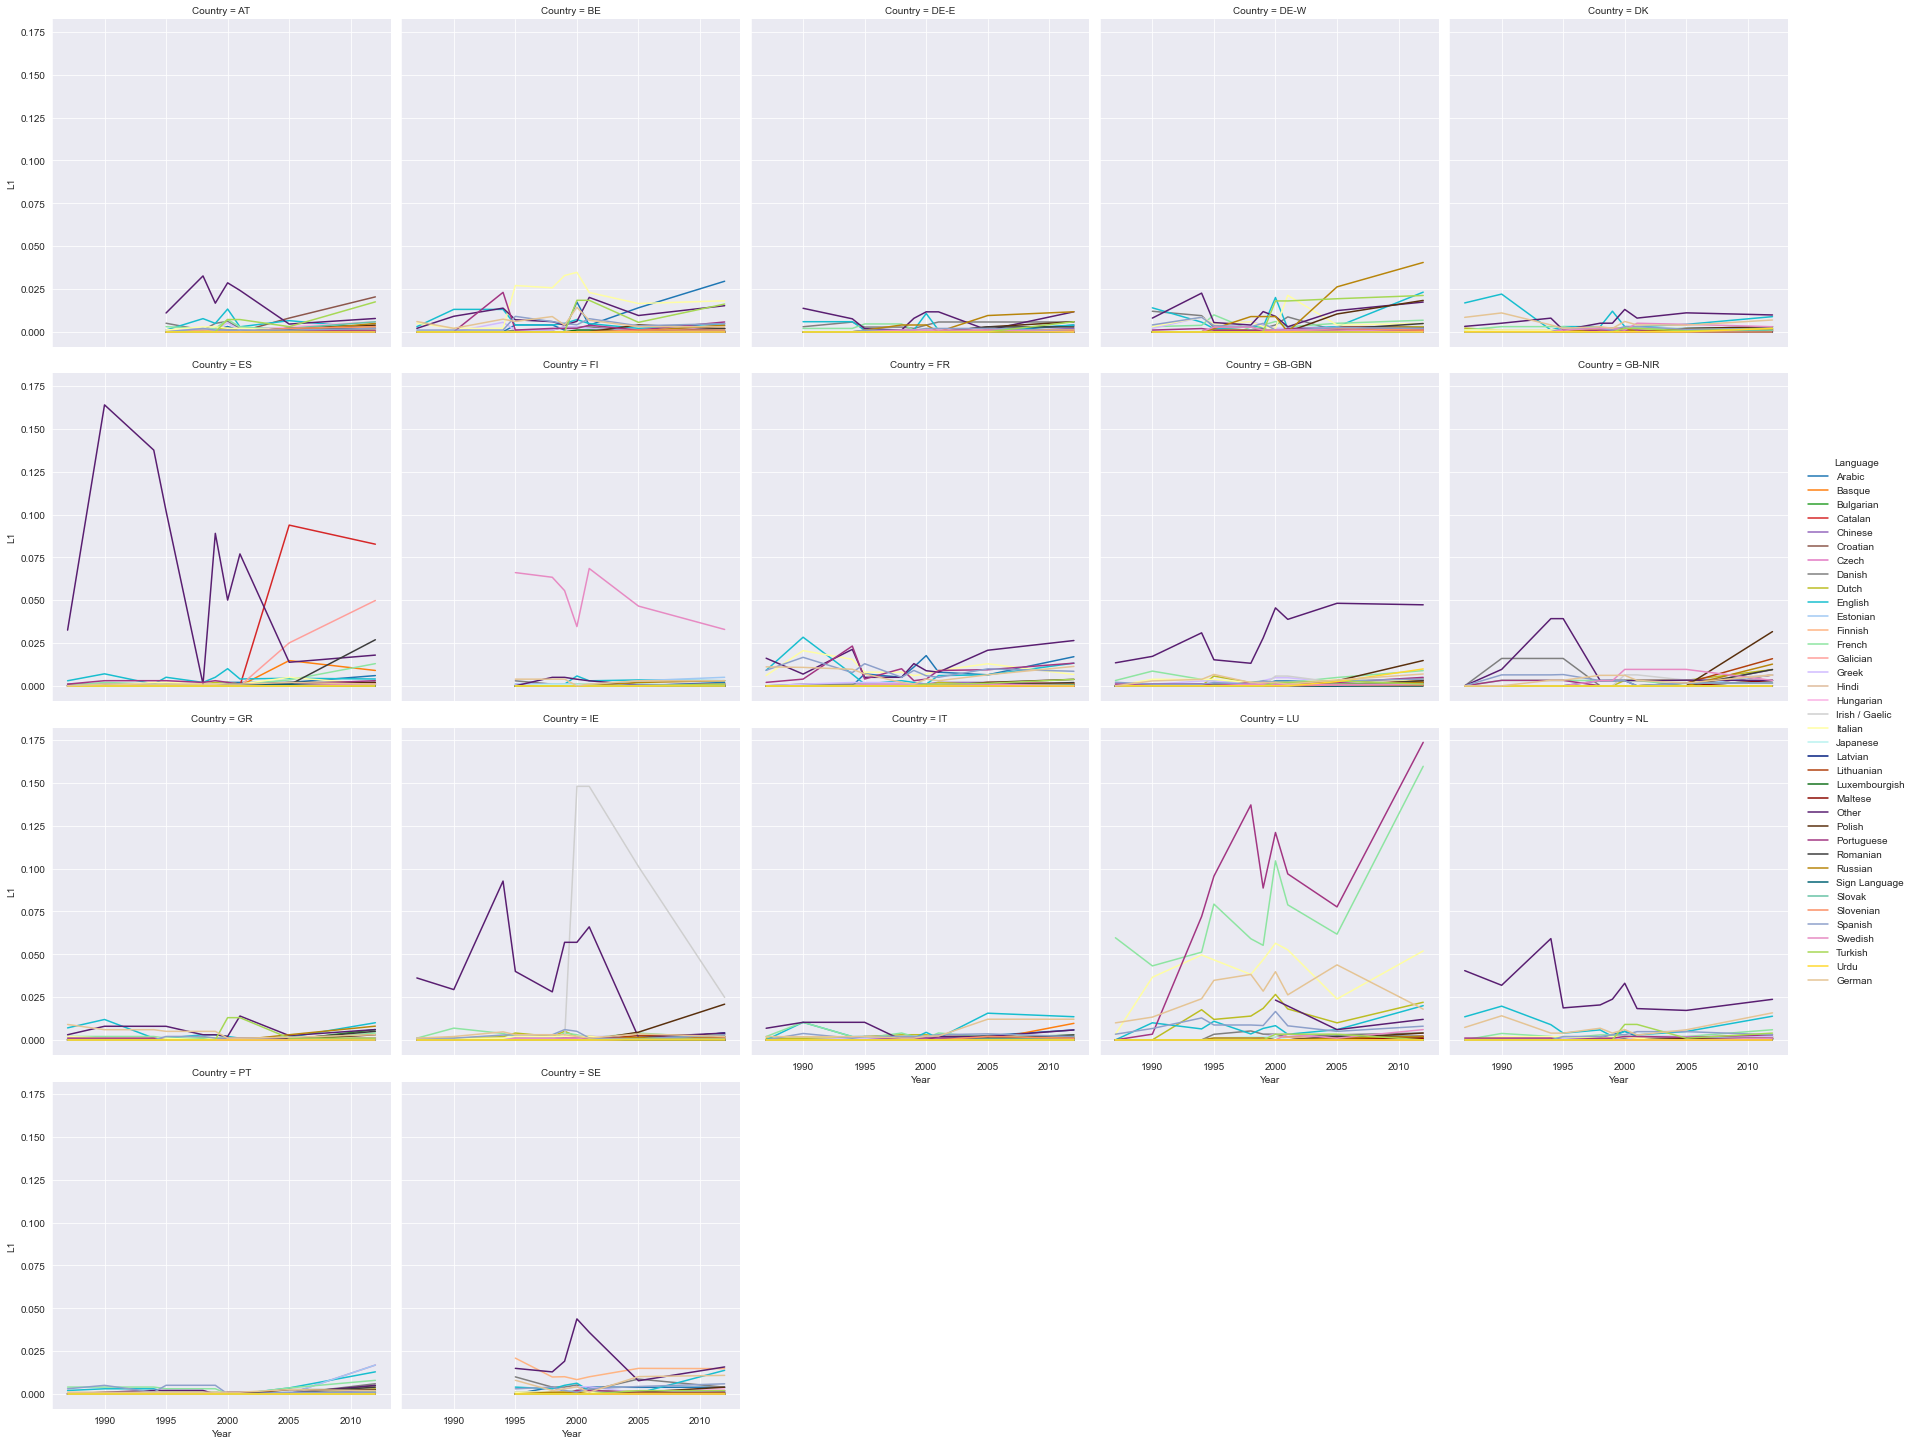

In [15]:
sns.relplot(
    data=agg_long[agg_long.L1 < 0.2],
    x="Year", y="L1",
    hue="Language", col='Country', col_wrap=5,
    kind="line", palette=pal[:len(agg_long.reset_index().Language.unique())]
)